In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
from bokeh.plotting import show, figure
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data = pd.read_csv("Family_Income_and_Expenditure.csv") 

In [3]:
# spliting data in numeric and text
colnumber = len(data.columns)
data_number = pd.DataFrame()
data_text = pd.DataFrame()
for i in range(colnumber):
    if data.dtypes[i] == "int64":
        data_number[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])
    else:
        data_text[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])

# 3. Model 2 - RandomForestRegressor

## 3.1. Model only with numeric data

In [19]:
data_number_a = pd.get_dummies(data_number, columns=["Agricultural Household indicator"])

In [20]:
np.random.seed(42)
mask = np.random.rand(data_number_a.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number_a[mask].shape, data_number_a[~mask].shape))

Train set shape (29197, 47), test set shape (12347, 47)


In [21]:
mean = data_number_a[mask].mean()
std = data_number_a[mask].std()
# Standard scaler
data_number_a_scaled = (data_number_a - mean) / std

### finding best parameters:

**n_estimators**

In [7]:
results = []
n_estimator_options = [30, 40, 50, 60, 100, 200]

for trees in n_estimator_options:
    rf = RandomForestRegressor(n_estimators = trees, random_state = 42)
    rf.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
    print(trees, "trees")
    pred = rf.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
    RMSE = np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))
    print('RMSE = {0:.04f}'.format(RMSE))
    results.append(RMSE)

30 trees
RMSE = 0.5412
40 trees
RMSE = 0.5369
50 trees
RMSE = 0.5329
60 trees
RMSE = 0.5329
100 trees
RMSE = 0.5360
200 trees
RMSE = 0.5343
500 trees
RMSE = 0.5339


Best n_estimator parameter is 50.

**max-depth**

In [13]:
results = []
max_depth_options = [10 ,14, 17, 19, 20, 21, 22, 24]

for depth in max_depth_options:
    rf = RandomForestRegressor(n_estimators = 50, max_depth = depth, random_state = 42)
    rf.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
    print(depth, "depth")
    pred = rf.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
    RMSE = np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))
    print('RMSE = {0:.04f}'.format(RMSE))
    results.append(RMSE)

10 depth
RMSE = 0.5443
14 depth
RMSE = 0.5378
17 depth
RMSE = 0.5391
19 depth
RMSE = 0.5384
20 depth
RMSE = 0.5332
21 depth
RMSE = 0.5371
22 depth
RMSE = 0.5416
24 depth
RMSE = 0.5353


Better left max_depth = none

In [24]:
rf = RandomForestRegressor(n_estimators=50, random_state = 42)
rf.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
pred = rf.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
print('RMSE_scaled = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))))
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_number_a[~mask]["Total Household Income"])**2))))
# R^2
score = rf.score(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_number_a_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE_scaled = 0.5329
RMSE = 149797.66
R^2 = 0.9786


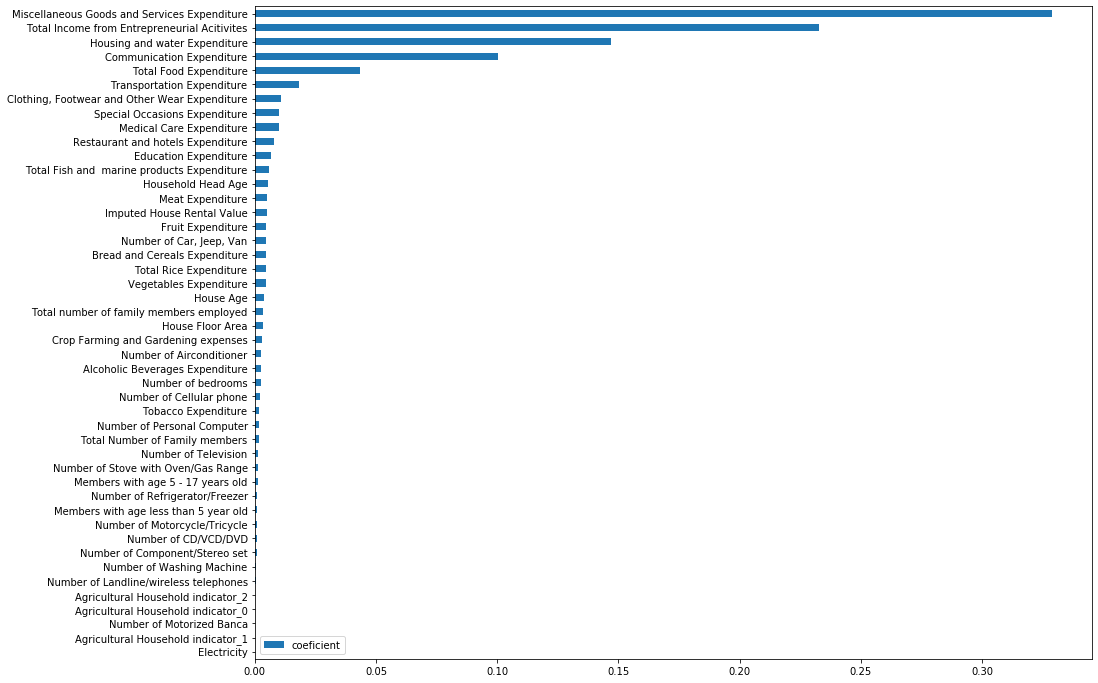

In [25]:
variable_importance = pd.DataFrame(rf.feature_importances_, columns=['coeficient'], index = data_number_a_scaled[mask].drop(["Total Household Income"], axis = 1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))

Random Forest get: RMSE_scaled = 0.5329; RMSE = 149 797.66. This is better than LR model. 

Best linear regresion model get RMSE_scaled = 0.5421; RMSE = 152 404.92 

## 3.2. Model with all data

In [4]:
data_text_recode = pd.get_dummies(data_text)
data_number_a = pd.get_dummies(data_number, columns=["Agricultural Household indicator"])

In [5]:
data_total = pd.DataFrame()
data_total = pd.concat([data_number_a, data_text_recode], axis = 1)
data_total.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,"Main Source of Water Supply_Lake, river, rain and others",Main Source of Water Supply_Others,"Main Source of Water Supply_Own use, faucet, community water system","Main Source of Water Supply_Own use, tubed/piped deep well",Main Source of Water Supply_Peddler,"Main Source of Water Supply_Protected spring, river, stream, etc","Main Source of Water Supply_Shared, faucet, community water system","Main Source of Water Supply_Shared, tubed/piped deep well",Main Source of Water Supply_Tubed/piped shallow well,"Main Source of Water Supply_Unprotected spring, river, stream, etc"
0,480332,117848,42140,38300,24676,16806,3325,13460,3000,0,...,0,0,1,0,0,0,0,0,0,0
1,198235,67766,17329,13008,17434,11073,2035,7833,2360,960,...,0,0,1,0,0,0,0,0,0,0
2,82785,61609,34182,32001,7783,2590,1730,3795,4545,270,...,0,0,0,0,0,0,1,0,0,0


In [6]:
# split data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_total.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_total[mask].shape, data_total[~mask].shape))

Train set shape (29197, 557), test set shape (12347, 557)


### Finding best parameters

#### n_estimators

In [52]:
results = []
n_estimator_options = [30, 40, 50, 60, 70, 100, 200, 500]

for trees in n_estimator_options:
    rf = RandomForestRegressor(n_estimators = trees, random_state = 42)
    rf.fit(data_total[mask].drop(["Total Household Income"], axis=1),
       data_total[mask]["Total Household Income"])
    print(trees, "trees")
    pred = rf.predict(data_total[~mask].drop(["Total Household Income"], axis=1))
    RMSE = np.sqrt(np.mean((pred - data_total[~mask]["Total Household Income"])**2))
    print('RMSE = {0:.04f}'.format(RMSE))
    results.append(RMSE)

30 trees
RMSE = 152906.2176
40 trees
RMSE = 151598.4834
50 trees
RMSE = 151142.0574
60 trees
RMSE = 150829.7090
70 trees
RMSE = 151318.4226
100 trees
RMSE = 151318.6817
200 trees
RMSE = 150772.0425
500 trees
RMSE = 150595.3467


Best with 60 trees

#### max_depth

In [8]:
results = []
max_depth_options = [10 ,14, 15, 16, 17]

for depth in max_depth_options:
    rf = RandomForestRegressor(n_estimators = 60, max_depth = depth, random_state = 42)
    rf.fit(data_total[mask].drop(["Total Household Income"], axis=1),
       data_total[mask]["Total Household Income"])
    print(depth, "depth")
    pred = rf.predict(data_total[~mask].drop(["Total Household Income"], axis=1))
    RMSE = np.sqrt(np.mean((pred - data_total[~mask]["Total Household Income"])**2))
    print('RMSE = {0:.04f}'.format(RMSE))
    results.append(RMSE)

10 depth
RMSE = 152480.5901
14 depth
RMSE = 150643.0802
15 depth
RMSE = 149886.3949
16 depth
RMSE = 150747.9102
17 depth
RMSE = 150875.9683


Best trees depth is 15.

#### Best model:

In [7]:
rf = RandomForestRegressor(n_estimators=60, max_depth = 15, random_state = 42)
rf.fit(data_total[mask].drop(["Total Household Income"], axis=1),
       data_total[mask]["Total Household Income"])
pred = rf.predict(data_total[~mask].drop(["Total Household Income"], axis=1))
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_total[~mask]["Total Household Income"])**2))))
# R^2
score = rf.score(data_total[mask].drop(["Total Household Income"], axis=1),
                 data_total[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

RMSE = 149886.3949
R^2 = 0.9681


In [16]:
variable_importance = pd.DataFrame(rf.feature_importances_, columns=['coeficient'], index = data_total[mask].drop(["Total Household Income"], axis = 1).columns)
variable_importance.sort_values(by = ["coeficient"], ascending = 0).head(40)
#.plot(kind='barh', figsize=(15,20))

,coeficient
Miscellaneous Goods and Services Expenditure,0.336110
Total Income from Entrepreneurial Acitivites,0.232721
Housing and water Expenditure,0.150816
Communication Expenditure,0.097482
Total Food Expenditure,0.042785
Transportation Expenditure,0.016517
"Clothing, Footwear and Other Wear Expenditure",0.008846
Special Occasions Expenditure,0.008663
Medical Care Expenditure,0.007990
Restaurant and hotels Expenditure,0.005807


# 4. Model 3 - GradientBoostingRegressor (left but this isn't better model)

In [76]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42, loss='ls')
gb.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
pred = gb.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))))

RMSE = 0.5353


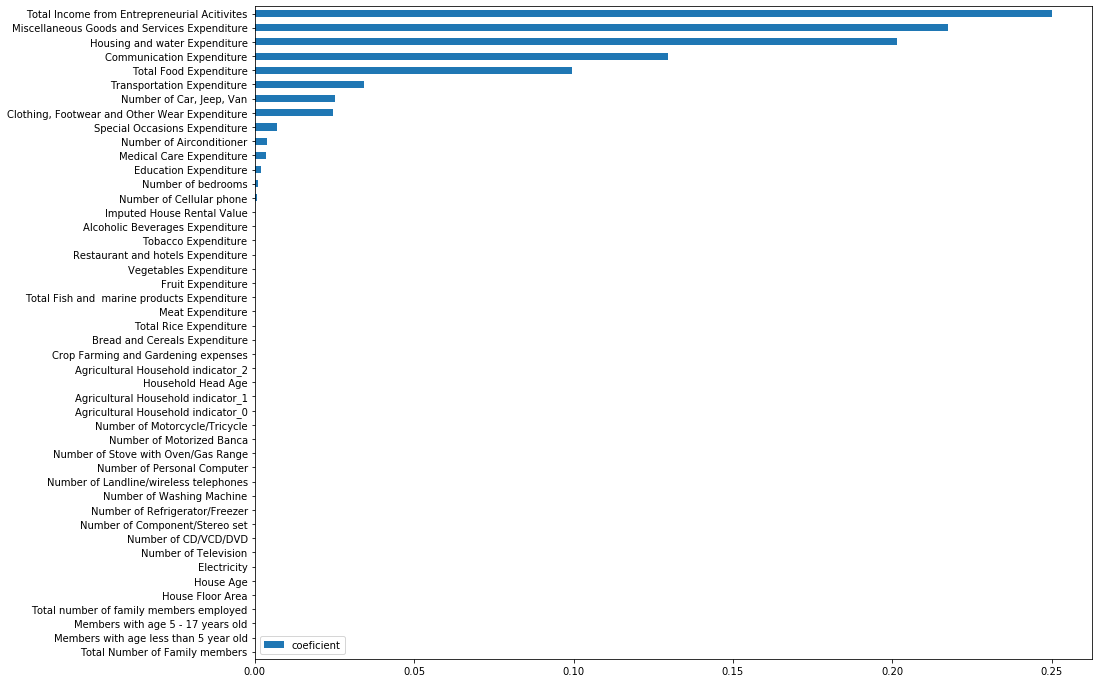

In [71]:
variable_importance = pd.DataFrame(gb.feature_importances_, columns=['coeficient'], index = data_number_a[mask].drop(["Total Household Income"], axis = 1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))

RMSE = 0.5353

Finding better parameters

In [78]:
results = []
n_estimator_options = [50, 100, 400, 500, 600, 1000]

for trees in n_estimator_options:
    gb = GradientBoostingRegressor(n_estimators=trees, learning_rate=0.1, random_state=42, loss='ls')
    gb.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
    print(trees, "trees")
    pred = gb.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
    RMSE = np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))
    print('RMSE = {0:.04f}'.format(RMSE))
    results.append(RMSE)

50 trees
RMSE = 0.5429
100 trees
RMSE = 0.5353
400 trees
RMSE = 0.5346
500 trees
RMSE = 0.5340
600 trees
RMSE = 0.5356
1000 trees
RMSE = 0.5381


In [81]:
results = []
n_estimator_options = [20, 50, 60, 70, 80, 100]

for trees in n_estimator_options:
    gb = GradientBoostingRegressor(n_estimators=trees, learning_rate=0.2, random_state=42, loss='ls')
    gb.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
    print(trees, "trees")
    pred = gb.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
    RMSE = np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))
    print('RMSE = {0:.04f}'.format(RMSE))
    results.append(RMSE)

20 trees
RMSE = 0.5503
50 trees
RMSE = 0.5351
60 trees
RMSE = 0.5339
70 trees
RMSE = 0.5343
80 trees
RMSE = 0.5348
100 trees
RMSE = 0.5369


Best n_estimators = 60 tress, learning_rate = 0.2 => RMSE = 0.5339

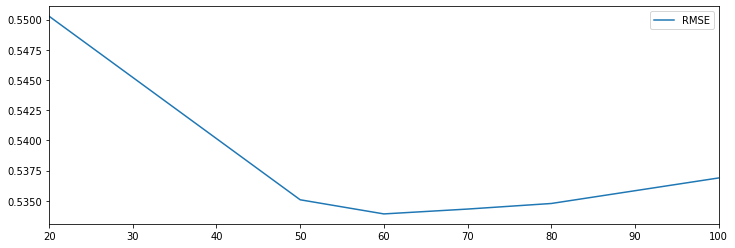

In [82]:
pd.DataFrame(results, n_estimator_options, columns=['RMSE']).plot(kind='line', figsize=(12,4))

In [83]:
gb = GradientBoostingRegressor(n_estimators=60, learning_rate=0.2, random_state=42, loss='ls')
gb.fit(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
       data_number_a_scaled[mask]["Total Household Income"])
pred = gb.predict(data_number_a_scaled[~mask].drop(["Total Household Income"], axis=1))
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_a_scaled[~mask]["Total Household Income"])**2))))

RMSE = 0.5339


In [87]:
score = gb.score(data_number_a_scaled[mask].drop(["Total Household Income"], axis=1),
                 data_number_a_scaled[mask]["Total Household Income"])
print('R^2 = {0:.04f}'.format(score))

R^2 = 0.9102


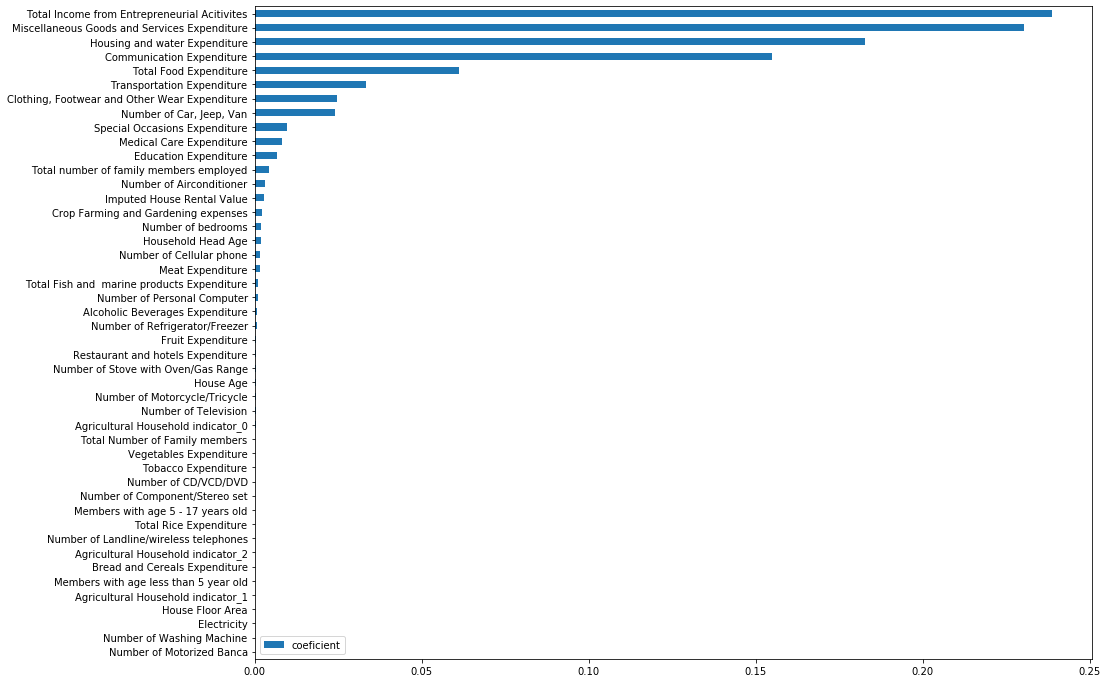

In [84]:
variable_importance = pd.DataFrame(gb.feature_importances_, columns=['coeficient'], index = data_number_a[mask].drop(["Total Household Income"], axis = 1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))